# BT4222 Assignment 3
By Teo Zhi Feng (A0203989N)

# 1 Setup

#### Import packages

In [1]:
import numpy as np
import tensorflow as tf

#np.random.seed(1234)
#tf.random.set_seed(1234)

In [2]:
from __future__ import print_function

from numpy.random import seed
from tensorflow.random import set_seed

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv1D, Dense, Dropout, Embedding, Flatten, GlobalMaxPooling1D,  LSTM, MaxPooling1D, TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import string
import re

#### Determine parameters

In [3]:
epochs = 10
batch_size = 128 # Select a batch size to fully utilise GPU memory, or 16 or 32

embedding_dims = 200 #50 # emddeding for each word
maxlen = 800 # max number of words in the review

filters = 250
kernel_size = 3 # size of the 1D conv. layer
hidden_dims = 128 # number of dimensions

metrics = ['accuracy', "Precision", "Recall"]


#### Import IMDB Dataset

In [4]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  44.1M      0  0:00:01  0:00:01 --:--:-- 44.1M


#### Inspect folder directory

In [5]:
!ls aclImdb
!ls aclImdb/test
!ls aclImdb/train

imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


In [6]:
!rm -r aclImdb/train/unsup

#### Import all datasets

In [7]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 157
Number of batches in raw_val_ds: 40
Number of batches in raw_test_ds: 196


#### Inspect dataset

In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b"I gave this a four purely out of its historical context. It was considered lost for many years until it popped up out of the blue on Showtime in the early nineties.<br /><br />Moe is the straight man and Larry and Curly act as a duo. Spade Cooley has a couple of numbers. I guess it had something to do with working on a ranch. I'm not quite sure because the plot was so minimal nothing really sticks in my memory. I vaguely remember it being a western musical comedy. Even the Stooge's seem to be going through the motions. Overall there's nothing much really to recommend here.<br /><br />If you're not a Stooge fan then don't bother. If you are a Stooge fan, then stick with the shorts."
0
b'First than anything, I\'m not going to praise I\xc3\xb1arritu\'s short film, even I\'m Mexican and proud of his success in mainstream Hollywood.<br /><br />In another hand, I see most of the reviews focuses on their favorite (and not so) short films; but we are forgetting that there is a subtle bottom 

#### Define list to store model performance

In [9]:
results = {}

# 2 Data Pre-Processing

#### Vectorise data

In [10]:
# Define custom function
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

# Model constants.
max_features = 20000

# Instantiate text vectorisation layer to normalize, split, and map strings to integers.
# We also set an explicit maximum sequence length, since the CNNs later in our model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=maxlen,
)

# With vocab layer, call `adapt` on a text-only dataset to create the vocabulary. 
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [11]:
print(len(vectorize_layer.get_vocabulary()))
print(vectorize_layer.get_vocabulary()[:20])

20000
['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'this', 'i', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film']


In [12]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

#### Inspect vectorised dataset

In [13]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'OK, so the musical pieces were poorly written and generally poorly sung (though Walken and Marner, particularly Walken, sounded pretty good). And so they shattered the fourth wall at the end by having the king and his nobles sing about the "battle" with the ogre, and praise the efforts of Puss in Boots when they by rights shouldn\'t have even known about it.<br /><br />Who cares? It\'s Christopher Freakin\' Walken, doing a movie based on a fairy tale, and he sings and dances. His acting style fits the role very well as the devious, mischievous Puss who seems to get his master into deeper and deeper trouble but in fact has a plan he\'s thought about seven or eight moves in advance. And if you\'ve ever seen Walken in any of his villainous roles, you *know* the ogre bit the dust HARD at the end when Walken got him into his trap.<br /><br />A fun film, and a must-see for anyone who enjoys the unique style of Christopher Walken.', shape=(), dtype=string)
Label pos
Vectori

# 3 Convolutional Neural Network (CNN)

#### Build model

In [14]:
model_cnn = Sequential()

model_cnn.add(Embedding(max_features,
                     embedding_dims,
                     input_length=maxlen))
model_cnn.add(Dropout(0.5))

# Convolution and pooling layer 1
model_cnn.add(Conv1D(filters,
                 kernel_size,
                 padding='same',
                 activation='relu',
                 strides=1))
model_cnn.add(GlobalMaxPooling1D())

##### OTHER CONVOLUTION LAYERS #####
# model_cnn.add(Conv1D(128,
#                  7,
#                  padding='same',
#                  activation='relu',
#                  strides=3,
#                  name='convolution1'))


# Flatten before connecting to dense layer 
model_cnn.add(Flatten())

model_cnn.add(Dense(hidden_dims, activation='relu'))
model_cnn.add(Dropout(0.5))

# Project onto a single unit, dense output layer and apply sigmoid activation function
# to make 0 or 1 predictions for the two classes (positive or negative).
model_cnn.add(Dense(1, activation='sigmoid', name='predictions'))

# Use binary_crossentropy loss function as it is a binary classification problem 
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

#### Visualise model

In [15]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 800, 200)          4000000   
_________________________________________________________________
dropout (Dropout)            (None, 800, 200)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 800, 250)          150250    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32128     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

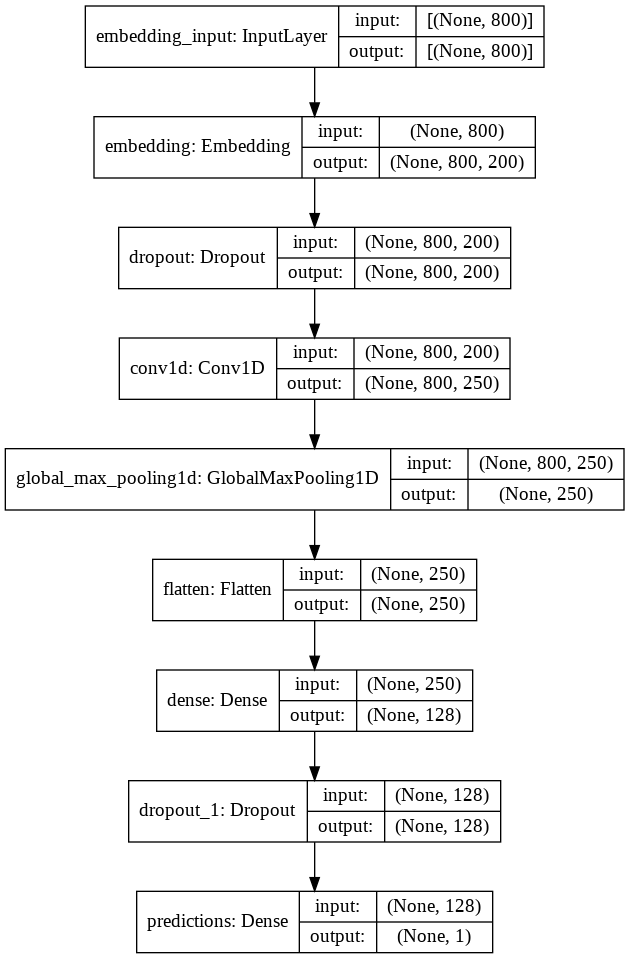

In [16]:
plot_model(model_cnn, show_shapes=True)

#### Train model using train dataset

In [17]:
# Fit model using train dataset
history_cnn = model_cnn.fit(train_ds,
              epochs=epochs,
              verbose = 1,
              batch_size=batch_size,
              validation_data=val_ds,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])

Epoch 1/10
157/157 [==============================] - 333s 2s/step - loss: 0.5980 - accuracy: 0.6554 - precision: 0.6553 - recall: 0.6521 - val_loss: 0.4099 - val_accuracy: 0.8144 - val_precision: 0.8027 - val_recall: 0.8384
Epoch 2/10
157/157 [==============================] - 325s 2s/step - loss: 0.3279 - accuracy: 0.8619 - precision: 0.8555 - recall: 0.8703 - val_loss: 0.2808 - val_accuracy: 0.8830 - val_precision: 0.8792 - val_recall: 0.8906
Epoch 3/10
157/157 [==============================] - 323s 2s/step - loss: 0.2065 - accuracy: 0.9233 - precision: 0.9203 - recall: 0.9265 - val_loss: 0.2675 - val_accuracy: 0.8866 - val_precision: 0.8697 - val_recall: 0.9120
Epoch 4/10
157/157 [==============================] - 324s 2s/step - loss: 0.1326 - accuracy: 0.9531 - precision: 0.9518 - recall: 0.9544 - val_loss: 0.3050 - val_accuracy: 0.8834 - val_precision: 0.8477 - val_recall: 0.9374
Epoch 5/10
157/157 [==============================] - 328s 2s/step - loss: 0.0866 - accuracy: 0.9693

KeyboardInterrupt: ignored

In [ ]:
figure, axis = plt.subplots(2, sharex=True)

axis[0].plot(history_cnn.history['loss'], label='train')
axis[0].plot(history_cnn.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_title('Loss')

axis[1].plot(history_cnn.history['accuracy'], label='train')
axis[1].plot(history_cnn.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_title('Accuracy')

plt.show()

#### Evaluate model performance on test dataset

In [ ]:
metrics_cnn = model_cnn.evaluate(test_ds,verbose=1)

In [ ]:
loss_cnn = round(metrics_cnn[0], 3)
accuracy_cnn = round(metrics_cnn[1], 3)
precision_cnn = round(metrics_cnn[2], 3)
recall_cnn = round(metrics_cnn[3], 3)

print('Model performance on test set:\nLoss: {}\nAccuracy: {}\nPrecision: {}\nRecall: {}\n'.format(loss_cnn, accuracy_cnn, precision_cnn, recall_cnn))

In [ ]:
results['CNN'] = {
    'Loss': loss_cnn,
    'Accuracy': accuracy_cnn,
    'Precision': precision_cnn, 
    'Recall': recall_cnn,
    'F1-score': round( 2*((precision_cnn * recall_cnn) / (precision_cnn + recall_cnn)), 3 )
  }

# 4 Long Short-Term Memory (LSTM) 

### Build model

In [ ]:
model_lstm = Sequential()

model_lstm.add(Embedding(max_features,
                     embedding_dims,
                     input_length=maxlen))

model_lstm.add(LSTM(120, return_sequences=True))
model_lstm.add(GlobalMaxPooling1D())

model_lstm.add(Dense(1, activation='sigmoid', name='predictions'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

#### Visualise model

In [ ]:
model_lstm.summary()

In [ ]:
plot_model(model_lstm, show_shapes=True)

#### Train model using train dataset

In [ ]:
# Fit model using train dataset
history_lstm = model_lstm.fit(train_ds,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=val_ds,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])

In [ ]:
figure, axis = plt.subplots(2, sharex=True)

axis[0].plot(history_lstm.history['loss'], label='train')
axis[0].plot(history_lstm.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_title('Loss')

axis[1].plot(history_lstm.history['accuracy'], label='train')
axis[1].plot(history_lstm.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_title('Accuracy')

plt.show()

#### Evaluate model performance on test dataset

In [ ]:
metrics_lstm = model_lstm.evaluate(test_ds,verbose=1)

In [ ]:
loss_lstm = round(metrics_lstm[0], 3)
accuracy_lstm = round(metrics_lstm[1], 3)
precision_lstm = round(metrics_lstm[2], 3)
recall_lstm = round(metrics_lstm[3], 3)

print('Model performance on test set:\nLoss: {}\nAccuracy: {}\nPrecision: {}\nRecall: {}\n'.format(loss_lstm, accuracy_lstm, precision_lstm, recall_lstm))

In [ ]:
results['LSTM'] = {
    'Loss': loss_lstm,
    'Accuracy': accuracy_lstm,
    'Precision': precision_lstm, 
    'Recall': recall_lstm,
    'F1-score': round( 2*((precision_lstm * recall_lstm) / (precision_lstm + recall_lstm)), 3 )
  }

#### Get predictions

In [ ]:
threshold = 0.6

In [ ]:
predictions = np.array(model_lstm.predict(test_ds) > threshold, dtype=np.int32)

In [ ]:
test_labels = np.array([k[1].numpy() for k in test_ds.unbatch()])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision: {}'.format(precision_score(test_labels, predictions)))
print('Recall: {}'.format(recall_score(test_labels, predictions)))
print('F1: {}'.format(f1_score(test_labels, predictions)))

# 5 Model Comparison
Comparing CNN and LSTM, the results are summarised in the DataFrame below.

In [ ]:
results = pd.DataFrame(results)
results

From the results, we see that CNN performed better than LSTM, achieving a higher accuracy, precision, recall and F1 scores. This is because CNN is generally better at recognising local patterns. Given that the dataset contains movie reviews, CNN is likely to be better in identifying features. On the other hand, sequential information in movie reviews may not be significantly important.

Comments on CNN:
1. CNN is useful to recognise patterns across space and it is good at extracting local and position-invariant features. 
2. CNN is computationally faster.
3. CNN is better when feature detection in text is more important. 

Comments on LSTM/RNN:
1. LSTM/RNN is useful to recognise patterns across time and it captures long-term dependencies between word sequences.
2. LSTM/RNN is ideal for sequential data when the current step is related with the previous steps. It is also ideal for datasets with a time component and natural language processing. In particular, RNN performs well when sequential information is clearly important, which reduces the likelihood that the meaning being misinterpreted or the grammer being incorrect.
3. RNN is better when sequential modeling is more important.


# 6 Additional Insights

#### Insight 1: Wide vs deep neural network

Deep neural network (6 layers of CNN followed by 3 fully connected layers)

Very deep neural network (26 layers of CNN followed by 3 fully connected layers)

#### Insight 2: Different CNN/LSTM models
Different scholars have tried different combinations of CNN and LSTM layers in order to improve model performance.

Variation 1: CNN + LSTM

In [ ]:
model1 = Sequential()
model1.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model1.add(Dropout(0.5))

model1.add(Conv1D(filters,
                 kernel_size,
                 padding='same',
                 activation='relu',
                 strides=1))
model1.add(GlobalMaxPooling1D())

model_lstm.add(LSTM(120, return_sequences=True))
model_lstm.add(GlobalMaxPooling1D())

model1.add(Flatten())
model1.add(Dense(hidden_dims, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid', name='predictions'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
history1 = model1.fit(train_ds,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=val_ds,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])

Variation 2: Bidirectional LSTM

In [ ]:
model2 = Sequential()
model1.add(Embedding(max_features, embedding_dims, input_length=maxlen))
model2.add(Dropout(0.5))
model2.add(Bidirectional(LSTM(32, return_sequences = True)))
model2.add(GlobalMaxPool1D())
model1.add(Flatten())
model1.add(Dense(hidden_dims, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
history2 = model2.fit(train_ds,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=val_ds,
              callbacks=[EarlyStopping(monitor='val_loss',patience=3, min_delta=0.0001)])

#### Insight 3: Adjust threshold value

In [ ]:
threshold = [x/10 for x in range(1,10)]
test_labels = np.array([k[1].numpy() for k in test_ds.unbatch()])
results_threshold_cnn = {'Accuracy': {}, 'Precision': {}, 'Recall': {}, 'F1': {}}
results_threshold_lstm = {'Accuracy': {}, 'Precision': {}, 'Recall': {}, 'F1': {}}

for t in threshold:
  predictions_cnn = np.array(model_cnn.predict(test_ds) > t, dtype=np.int32)
  results_threshold_cnn['Accuracy']['CNN_' + str(t)] = accuracy_score(test_labels, predictions_cnn)
  results_threshold_cnn['Precision']['CNN_' + str(t)] = precision_score(test_labels, predictions_cnn)                           
  results_threshold_cnn['Recall']['CNN_' + str(t)] = recall_score(test_labels, predictions_cnn)
  results_threshold_cnn['F1']['CNN_' + str(t)] = f1_score(test_labels, predictions_cnn)

  predictions_lstm = np.array(model_cnn.predict(test_ds) > t, dtype=np.int32)
  results_threshold_lstm['Accuracy']['LSTM_' + str(t)] = accuracy_score(test_labels, predictions_lstm)
  results_threshold_lstm['Precision']['LSTM_' + str(t)] = precision_score(test_labels, predictions_lstm)
  results_threshold_lstm['Recall']['LSTM_' + str(t)] = recall_score(test_labels, predictions_lstm)
  results_threshold_lstm['F1']['LSTM_' + str(t)] = f1_score(test_labels, predictions_lstm)

In [ ]:
results_threshold_cnn = pd.DataFrame(results_threshold_cnn)
results_threshold_cnn

#### Insight 4: Word embedding techniques
Different word embedding techniques may affect the model performances. Other types of word embedding techniques could have been used, such as word2vec.